# **Milestone 2**

We have built two Convolutional Neural Network architectures in Milestone 1. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start this Milestone with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. Please feel free to explore other pre-trained models as well. Link to Keras documentation for pre-trained models - https://keras.io/api/applications/

**Note:** We will mount our drive and import our dataset once again for Milestone 2.

## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is not a library that can be downloaded locally on your device.**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the Libraries**

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. Unlike in Milestone 1, we will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(rescale = 1./25)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation", target_size = (img_size, img_size),
                                                        color_mode = 'rgb', batch_size = batch_size, class_mode = 
                                                        'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                        shuffle = False)

datagen_test = ImageDataGenerator(rescale = 1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test", target_size = (img_size, img_size), color_mode = 'rgb',
                                            batch_size = batch_size, class_mode = 'categorical', classes = 
                                            ['happy', 'sad', 'neutral', 'surprise'], shuffle = False)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. You can scroll down in the model summary and look for 'block5_pool'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False

# Add classification layers on top of it  
transfer_layer = vgg.get_layer('block5_pool')

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

### **Compiling and Training the VGG16 Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'. 

vggmodel.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [ ]:
 # Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.

history = vggmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 448s 944ms/step - loss: 1.3211 - accuracy: 0.3836 - val_loss: 1.3291 - val_accuracy: 0.4282
Epoch 2/20
473/473 [==============================] - 450s 952ms/step - loss: 1.2202 - accuracy: 0.4404 - val_loss: 1.4952 - val_accuracy: 0.4577
Epoch 3/20
473/473 [==============================] - 476s 1s/step - loss: 1.1862 - accuracy: 0.4614 - val_loss: 1.4436 - val_accuracy: 0.4237
Epoch 4/20
473/473 [==============================] - 474s 1s/step - loss: 1.1698 - accuracy: 0.4740 - val_loss: 1.8234 - val_accuracy: 0.3824
Epoch 5/20
473/473 [==============================] - 474s 1s/step - loss: 1.1565 - accuracy: 0.4797 - val_loss: 1.8298 - val_accuracy: 0.4087
Epoch 6/20
473/473 [==============================] - 476s 1s/step - loss: 1.1524 - accuracy: 0.4859 - val_loss: 1.8358 - val_accuracy: 0.4270
Epoch 7/20
473/473 [==============================] - 476s 1s/step - loss: 1.1399 - accuracy: 0.4920 - val_loss: 2.1102 - val_accuracy: 

### **Evaluating the VGG16 model**

In [ ]:
# Write your code to evaluate model performance on the test set

accuracy = vggmodel.evaluate(test_set, verbose = 2)

4/4 - 3s - loss: 1.0324 - accuracy: 0.5703 - 3s/epoch - 740ms/step


**Think About It:**

- What do you infer from the general trend in the training performance? 
- Is the training accuracy consistently improving? 
- Is the validation accuracy also improving similarly?

**Observations and Insights:__**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                          

### **Model Building**

* In this model, we will import till the **'conv5_block3_add'** layer of the ResNet model. You can scroll down in the model summary and look for 'conv5_block3_add'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'conv5_block3_add' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [ ]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

# Add classification layers on top of it
transfer_layer = Resnet.get_layer('conv5_block3_add')

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) 

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr = 0.00001, mode = 'min')


callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10

In [ ]:
# Write your code to compile your resnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'. 

resnetmodel.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [ ]:





# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.

history = resnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 345s 715ms/step - loss: 1.4881 - accuracy: 0.2563 - val_loss: 1.3896 - val_accuracy: 0.2542
Epoch 2/20
473/473 [==============================] - 336s 712ms/step - loss: 1.4033 - accuracy: 0.2679 - val_loss: 1.3910 - val_accuracy: 0.1609
Epoch 3/20
473/473 [==============================] - 341s 721ms/step - loss: 1.3980 - accuracy: 0.2626 - val_loss: 1.4051 - val_accuracy: 0.2345
Epoch 4/20
473/473 [==============================] - 340s 719ms/step - loss: 1.3977 - accuracy: 0.2634 - val_loss: 1.3665 - val_accuracy: 0.2441
Epoch 5/20
473/473 [==============================] - 339s 717ms/step - loss: 1.3951 - accuracy: 0.2600 - val_loss: 1.3916 - val_accuracy: 0.2439
Epoch 6/20
473/473 [==============================] - 342s 722ms/step - loss: 1.3911 - accuracy: 0.2655 - val_loss: 1.3590 - val_accuracy: 0.3667
Epoch 7/20
473/473 [==============================] - 339s 718ms/step - loss: 1.3906 - accuracy: 0.2634 - val_loss: 1.3728 -

### **Evaluating the ResNet Model**

In [ ]:
# Write your code to evaluate model performance on the test set

accuracy = resnetmodel.evaluate(test_set, verbose = 2)

4/4 - 2s - loss: 1.3874 - accuracy: 0.2500 - 2s/epoch - 524ms/step


**Observations and Insights:__**

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

**Build your own Architecture on top of the transfer layer. Be sure to have a Flatten layer after your transfer layer and also make sure you have 4 neurons and softmax activation function in your last dense layer**

In [ ]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

# Add your Flatten layer.
x = Flatten()(transfer_layer_EfficientNet.output)

# Add your Dense layers and/or BatchNormalization and Dropout layers
x = Dense(128, activation = 'relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.5)(x)
# Add your final Dense layer with 4 neurons and softmax activation function.
pred = Dense(4, activation = 'softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr = 0.00001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 10

In [ ]:
# Write your code to compile your Efficientnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'.

Efficientnetmodel.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.

history = Efficientnetmodel.fit(train_set, epochs = 20, validation_data = validation_set)

Epoch 1/20
473/473 [==============================] - 86s 166ms/step - loss: 1.5281 - accuracy: 0.2534 - val_loss: 1.5635 - val_accuracy: 0.1601
Epoch 2/20
473/473 [==============================] - 78s 165ms/step - loss: 1.4111 - accuracy: 0.2546 - val_loss: 1.3506 - val_accuracy: 0.3667
Epoch 3/20
473/473 [==============================] - 78s 166ms/step - loss: 1.3918 - accuracy: 0.2613 - val_loss: 1.3753 - val_accuracy: 0.2443
Epoch 4/20
473/473 [==============================] - 78s 165ms/step - loss: 1.3866 - accuracy: 0.2674 - val_loss: 1.3701 - val_accuracy: 0.3078
Epoch 5/20
473/473 [==============================] - 78s 165ms/step - loss: 1.3881 - accuracy: 0.2662 - val_loss: 1.3684 - val_accuracy: 0.2289
Epoch 6/20
473/473 [==============================] - 78s 166ms/step - loss: 1.3874 - accuracy: 0.2620 - val_loss: 1.3612 - val_accuracy: 0.3667
Epoch 7/20
473/473 [==============================] - 78s 165ms/step - loss: 1.3867 - accuracy: 0.2681 - val_loss: 1.3692 - val_ac

### **Evaluating the EfficientnetNet Model**

In [ ]:
# Write your code to evaluate the model performance on the test set

accuracy = Efficientnetmodel.evaluate(test_set, verbose = 2)

4/4 - 4s - loss: 1.4336 - accuracy: 0.2500 - 4s/epoch - 880ms/step


**Observations and Insights:__**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


datagen_validation = ImageDataGenerator(rescale = 1./255)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation", target_size = (img_size, img_size),
                                                        color_mode = 'grayscale', batch_size = batch_size, class_mode = 
                                                        'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                        shuffle = False)

datagen_test = ImageDataGenerator(rescale = 1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test", target_size = (img_size, img_size), color_mode = 'grayscale',
                                            batch_size = batch_size, class_mode = 'categorical', classes = ['happy',
                                                                                                            'sad',
                                                                                                            'neutral',
                                                                                                            'surprise'],
                                            shuffle = False)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

* In this network, we plan to have 5 Convolutional Blocks
* Add first Conv2D layer with **64 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input shape = (48, 48, 1)**. Use **'relu' activation**.
* Add your BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a Dropout layer with a Dropout Ratio of **0.2**. This completes the first Convolutional block.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **512 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **512 filters**.
* Add the fifth block, having **128 filters**.
* Then add your Flatten layer, followed by your Dense layers.
* Add your first Dense layer with **256 neurons** followed by a BatchNormalization layer, a **'relu'** Activation, and a Dropout layer. This forms your first Fully Connected block
* Add your second Dense layer with **512 neurons**, again followed by a BatchNormalization layer, **relu** activation, and a Dropout layer.
* Add your final Dense layer with 4 neurons.
* Compile your model with the optimizer of your choice.

In [ ]:
import tensorflow as tf


model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(64, kernel_size = 2, padding = 'same', input_shape = (48, 48, 1), activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 2nd CNN Block
model3.add(Conv2D(128, kernel_size = 2, padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 3rd CNN Block
model3.add(Conv2D(512, kernel_size = 2, padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 4th CNN Block
model3.add(Conv2D(512, kernel_size = 2, padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 5th CNN Block
model3.add(Conv2D(128, kernel_size = 2, padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

model3.add(Flatten())

# First fully connected layer
model3.add(Dense(256, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

# Second fully connected layer
model3.add(Dense(512, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Dense(4, activation = 'softmax'))

model3.compile(optimizer='adam', loss = 'categorical__crossentropy', metrics = ['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       3

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 35

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [ ]:
# Write your code to compile your model3. Use categorical crossentropy as the loss function, Adam Optimizer with 0.003 learning rate, and set metrics to 'accuracy'.

model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.003), metrics = ['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.

history = model3.fit(train_set, validation_data = validation_set, epochs = 35, batch_size = 32, shuffle = True)


Epoch 1/35
473/473 [==============================] - 353s 742ms/step - loss: 1.6043 - accuracy: 0.2702 - val_loss: 1.5952 - val_accuracy: 0.3675
Epoch 2/35
473/473 [==============================] - 355s 750ms/step - loss: 1.4699 - accuracy: 0.2729 - val_loss: 1.4739 - val_accuracy: 0.2431
Epoch 3/35
473/473 [==============================] - 356s 752ms/step - loss: 1.4283 - accuracy: 0.2959 - val_loss: 1.3669 - val_accuracy: 0.3665
Epoch 4/35
473/473 [==============================] - 361s 764ms/step - loss: 1.3294 - accuracy: 0.3524 - val_loss: 1.2190 - val_accuracy: 0.4274
Epoch 5/35
473/473 [==============================] - 356s 753ms/step - loss: 1.2630 - accuracy: 0.3945 - val_loss: 1.2762 - val_accuracy: 0.4899
Epoch 6/35
473/473 [==============================] - 359s 759ms/step - loss: 1.1954 - accuracy: 0.4496 - val_loss: 1.0904 - val_accuracy: 0.5184
Epoch 7/35
473/473 [==============================] - 354s 749ms/step - loss: 1.1146 - accuracy: 0.4983 - val_loss: 1.0700 -

### **Evaluating the Model on Test Set**

In [ ]:
# Write your code to evaluate the model performance on the test set

accuracy = model3.evaluate(validation_set, verbose = 2)

156/156 - 31s - loss: 0.6664 - accuracy: 0.7440 - 31s/epoch - 197ms/step


**Observations and Insights:__**

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 1s 158ms/step
              precision    recall  f1-score   support

       happy       0.74      0.72      0.73        32
         sad       0.60      0.75      0.67        32
     neutral       0.59      0.53      0.56        32
    surprise       0.93      0.81      0.87        32

    accuracy                           0.70       128
   macro avg       0.71      0.70      0.71       128
weighted avg       0.71      0.70      0.71       128



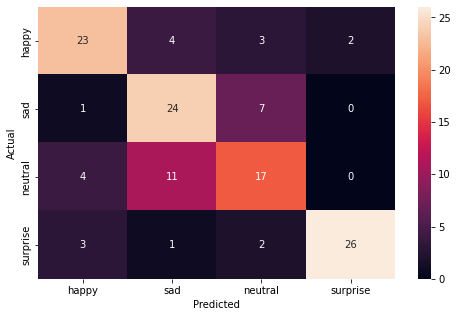

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred, target_names = ['happy', 'sad', 'neutral', 'surprise']))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:__**

## **Conclusion:____________**

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?